# Capstone Project
## Providing data-driven suggestions for HR

###### Main goal:
    to analyze the data collected by the HR department of Salifort Motors and to build a model that predicts whether or not an employee will leave the company.

In [1]:
#importing all the required packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#for displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#for displaying metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

#for saving models
import pickle


In [2]:
df0 = pd.read_csv("C:/Users/rohan/OneDrive/Desktop/Google Advanced Data Analytics, Capstone Project/HR_capstone_dataset.csv")
df0.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

### Data Exploration (EDA and data cleaning)

To understand the variables in the dataset,
and clean the dataset by identifying and removing any missing data, redundant data and outliers

##### Gathering any missing information about the data

In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


##### Descriptive statistics

In [4]:
df0.describe()

satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident          left  \
count          14999.000000        14999.000000   14999.000000  14999.000000   
mean             201.050337            3.498233       0.144610      0.238083   
std               49.943099            1.460136       0.351719      0.425924   
min               96.000000            2.000000       0.000000      0.000000   
25%              156.000000            3.000000       0.000000      0.000000   
50%              200.000000            3.000000       0.000000      0.000000   
75%              245.000000            4.000000       0.000000      0.000000   
max              310.000000           10.000000       1.000000      1.000000   

       promotion_last_5years  
count           14999.000000  
mean                0.021268  
std                 0.144281  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

Lets inspect the columns if we can rename the columns if needed. 

Lets standardize the coluumn names to snake_case and make them more concise.

In [5]:
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [6]:
df0 = df0.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})

#displaying column names after the update
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

Checking for any missing values in the data

In [7]:
df0.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

No missing vales in the data

In [8]:
#checking for duplicates
df0.duplicated().sum()

np.int64(3008)

In [9]:
df0[df0.duplicated()].head()

satisfaction_level  last_evaluation  number_project  \
396                 0.46             0.57               2   
866                 0.41             0.46               2   
1317                0.37             0.51               2   
1368                0.41             0.52               2   
1461                0.42             0.53               2   

      average_monthly_hours  tenure  work_accident  left  \
396                     139       3              0     1   
866                     128       3              0     1   
1317                    127       3              0     1   
1368                    132       3              0     1   
1461                    142       3              0     1   

      promotion_last_5years  department  salary  
396                       0       sales     low  
866                       0  accounting     low  
1317                      0       sales  medium  
1368                      0       RandD     low  
1461                      0       sales     low

In [10]:
#dropping duplicates and saving the new dataframe in a new variable
df1 = df0.drop_duplicates(keep='first')

In [11]:
df1.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years department  salary  
0       3              0     1                      0      sales     low  
1       6              0     1                      0      sales  medium  
2       4              0     1                      0      sales  medium  
3       5              0     1                      0      sales     low  
4       3              0     1                      0      sales     low

##### Checking outliers

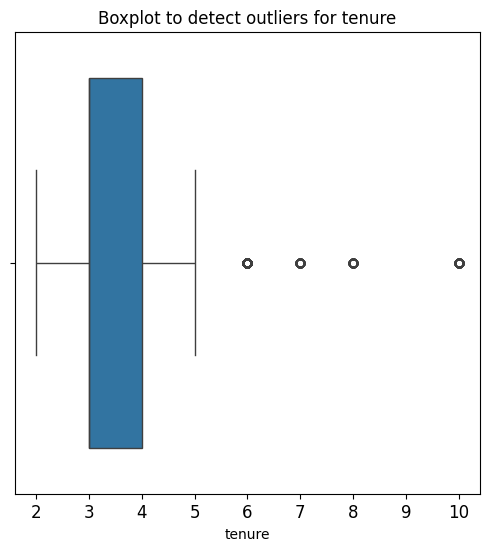

In [12]:
#creating a boxplot to visualize distribution of `tenure` and detect any outliers
plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for tenure', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df1['tenure'])
plt.show()

In [13]:
#using IQR method to detect outliers 

#the 25th percentile value in `tenure`
percentile25 = df1['tenure'].quantile(0.25)

#the 75th percentile value in `tenure`
percentile75 = df1['tenure'].quantile(0.75)

#the interquartile range in `tenure`
iqr = percentile75 - percentile25

#the upper limit and lower limit for non-outlier values in `tenure`
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

#identify subset of data containing outliers in `tenure`
outliers = df1[(df1['tenure'] > upper_limit) | (df1['tenure'] < lower_limit)]

#counting the rows in the data that contain outliers in `tenure`
print("Number of rows in the data containing outliers in `tenure`:", len(outliers))

Lower limit: 1.5
Upper limit: 5.5
Number of rows in the data containing outliers in `tenure`: 824


##### Continuing the data exploration

In [14]:
#to understand how many employees left and what percentage of all employees it represents

print(df1['left'].value_counts())
print()

#to get percentages of people who left vs. stayed
print(df1['left'].value_counts(normalize=True))

left
0    10000
1     1991
Name: count, dtype: int64

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64


#### Data Visualization

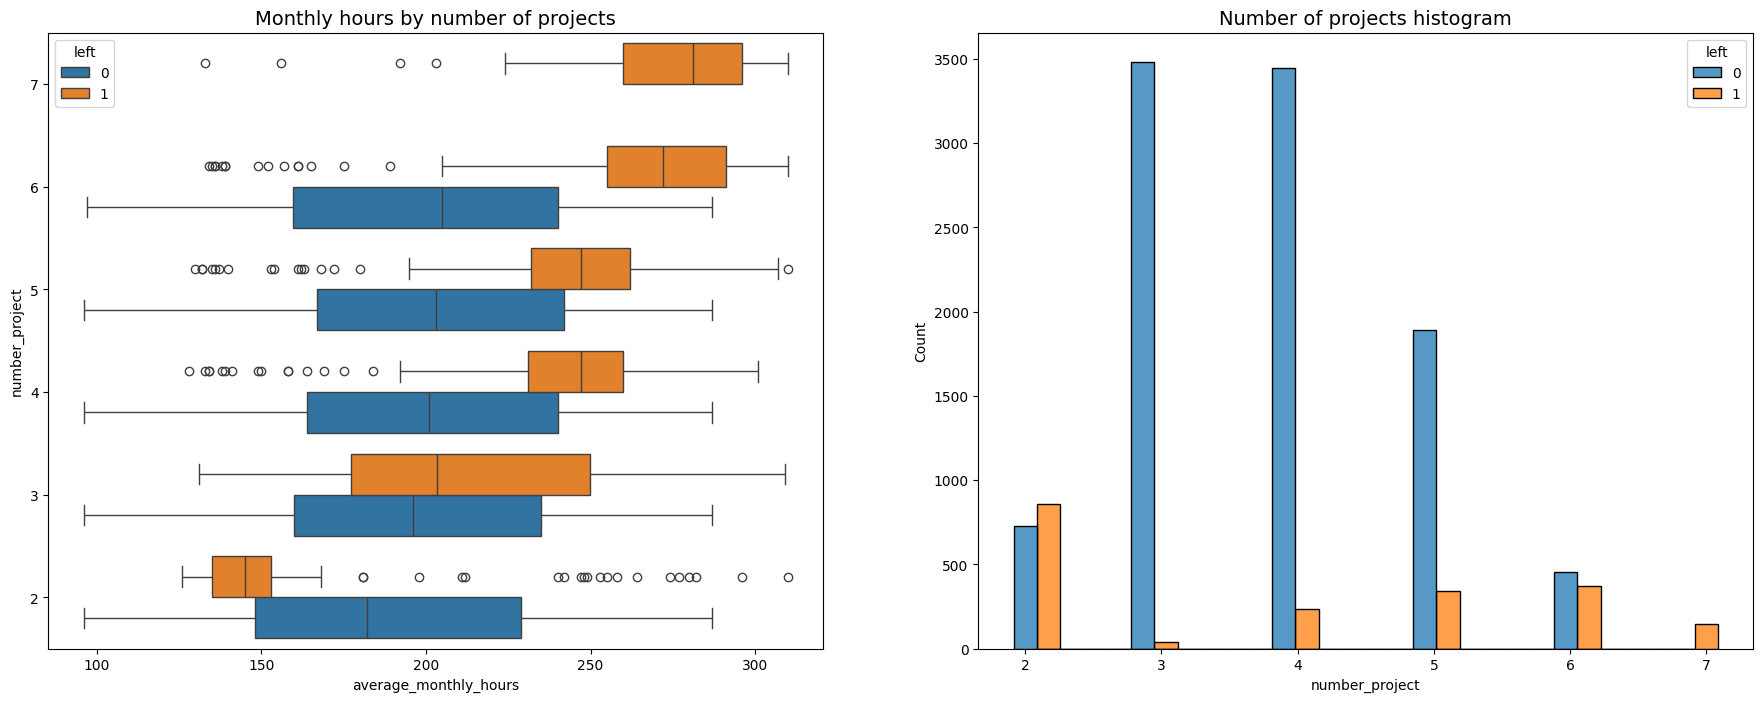

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

#creating a boxplot showing `average_monthly_hours` distributions for `number_project`,
#comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

#histogram showing distribution of `number_project`, comparing employees who stayed versus those who left
tenure_stay = df1[df1['left']==0]['number_project']
tenure_left = df1[df1['left']==1]['number_project']
sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')

plt.show()

#Note: '1' represents the employees who left and

It's natural that individuals handling more projects tend to invest more hours, as evident in the increasing mean hours for both groups (stayed and left) with project count. However, a few notable patterns emerge from this analysis.

- Among those who left the company, there are two distinct groups: (A) employees who worked significantly fewer hours compared to their counterparts on similar projects, and (B) those who put in considerably more hours. Group A may include individuals who were potentially let go, while it's plausible that this group also encompasses employees who had already given notice and had reduced workloads in preparation for departure. Group B likely consists of individuals who resigned, and their extensive contributions to projects are noteworthy.

- All employees with seven projects ultimately left, and both this group and those who left with six projects had interquartile ranges around 255–295 hours per week—much higher than any other cohort.

- The ideal project load for employees appears to be in the range of 3–4. These groups show a very low ratio of departures to retentions.

- If we assume a standard work week of 40 hours and two weeks of annual vacation, the average monthly working hours for employees working Monday–Friday would be approximately 166.67 hours. Interestingly, every group, even those who remained with the company, exceeded this benchmark, suggesting a prevailing culture of overwork within the organization.

In [16]:
#lets see the value counts of stayedor left for employees with 7 projects
df1[df1['number_project']==7]['left'].value_counts()

left
1    145
Name: count, dtype: int64

In [17]:
#this figure confirms that the employees with 7 projects did leave the company

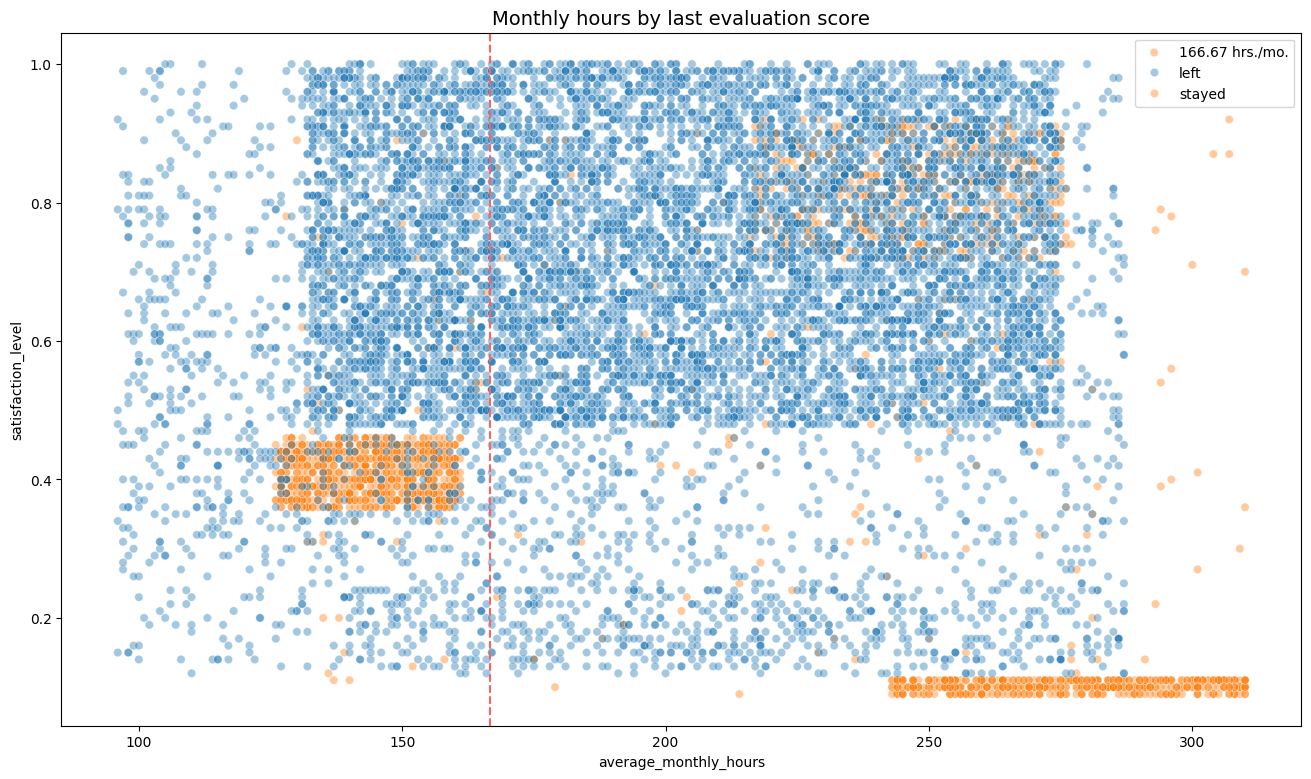

In [18]:
#lets create scatterplot of `average_monthly_hours` versus `satisfaction_level`
#comparing employees who stayed versus those who left
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

The scatterplot above shows that there was a sizeable group of employees who worked ~240–315 hours per month. 315 hours per month is over 75 hours per week for a whole year. It's likely this is related to their satisfaction levels being close to zero.

The plot also shows another group of people who left, those who had more normal working hours. Even so, their satisfaction was only around 0.4. It's difficult to speculate about why they might have left. It's possible they felt pressured to work more, considering so many of their peers worked more. And that pressure could have lowered their satisfaction levels.

Finally, there is a group who worked from 210–280 hours per month, and they had satisfaction levels ranging from 0.7–0.9.

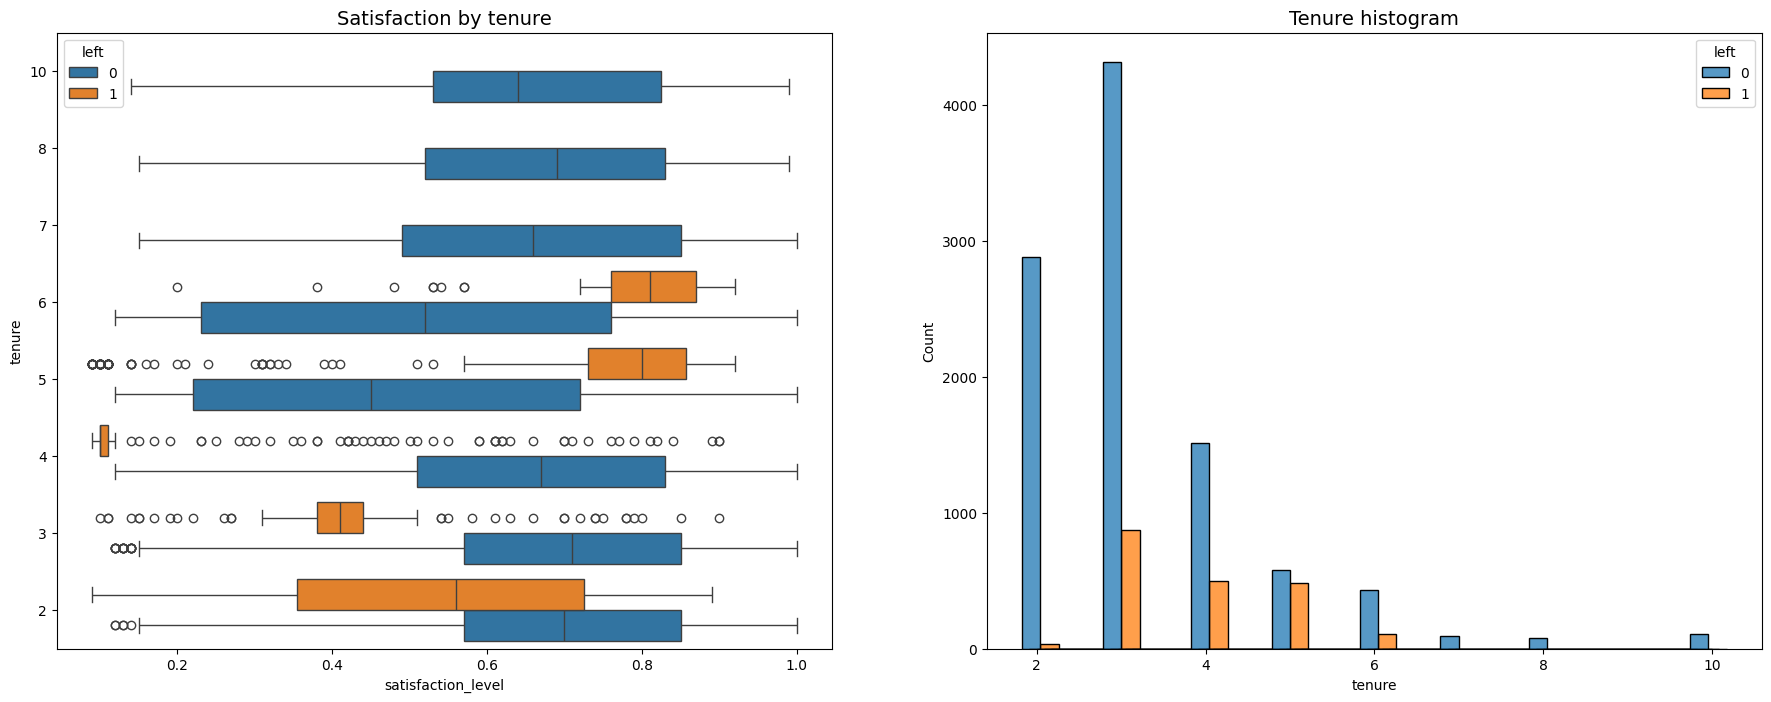

In [19]:
#lets visulaize satisfaction levels by tenure

fig, ax = plt.subplots(1, 2, figsize = (22,8))

#boxplot showing distributions of `satisfaction_level` by tenure, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='satisfaction_level', y='tenure', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

#histogram showing distribution of `tenure`, comparing employees who stayed versus those who left
tenure_stay = df1[df1['left']==0]['tenure']
tenure_left = df1[df1['left']==1]['tenure']
sns.histplot(data=df1, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')

plt.show();

Observations:
- Employees who left fall into two general categories: dissatisfied employees with shorter tenures and very satisfied employees with medium-length tenures.
- Four-year employees who left seem to have an unusually low satisfaction level. It's worth investigating changes to company policy that might have affected people specifically at the four-year mark, if possible.
- The longest-tenured employees didn't leave. Their satisfaction levels aligned with those of newer employees who stayed.
- The histogram shows that there are relatively few longer-tenured employees. It's possible that they're the higher-ranking, higher-paid employees.

In [20]:
#calculating the mean and median satisfaction scores of employees who left and those who stayed
df1.groupby(['left'])['satisfaction_level'].agg(['mean', 'median'])

mean  median
left                  
0     0.667365    0.69
1     0.440271    0.41

As expected, the mean and median satisfaction scores of employees who left are lower than those of employees who stayed. Interestingly, among employees who stayed, the mean satisfaction score appears to be slightly below the median score. This indicates that satisfaction levels among those who stayed might be skewed to the left.

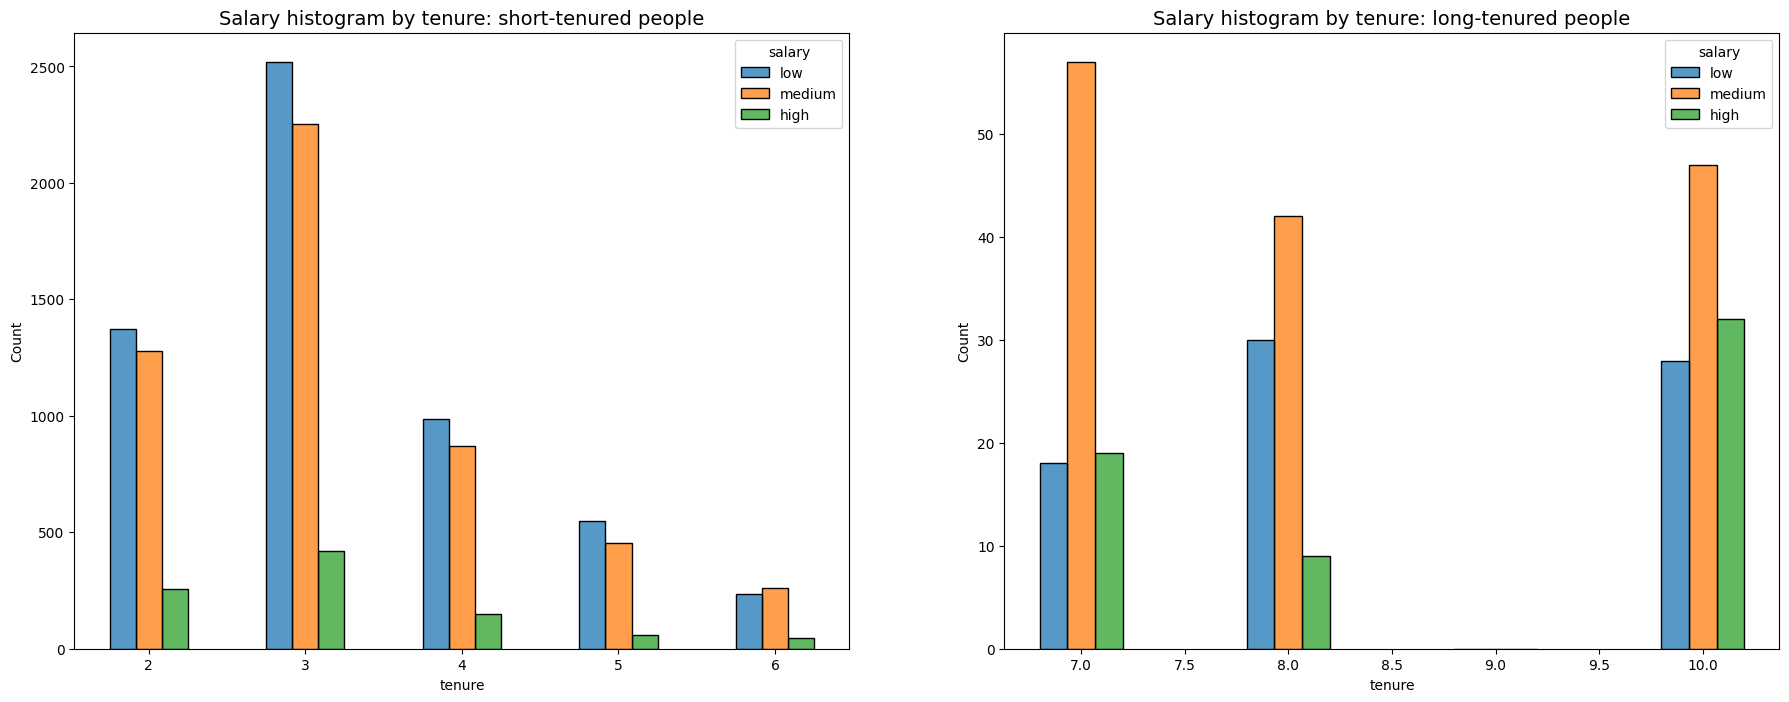

In [21]:
#now examining the salary levels for different tenures

fig, ax = plt.subplots(1, 2, figsize = (22,8))

#define short-tenured employees
tenure_short = df1[df1['tenure'] < 7]

#long-tenured employees
tenure_long = df1[df1['tenure'] > 6]

#short-tenured histogram
sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured people', fontsize='14')

#long-tenured histogram
sns.histplot(data=tenure_long, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured people', fontsize='14');

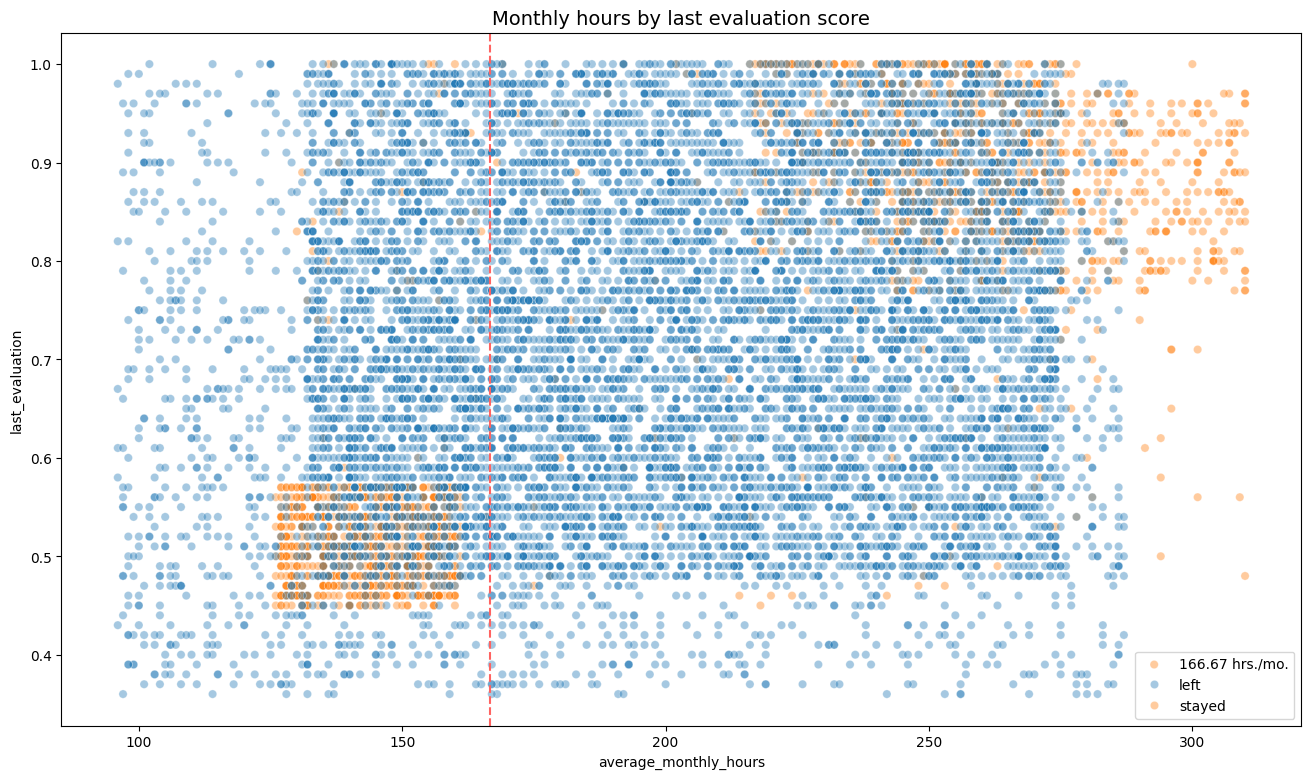

In [22]:
#creating scatterplot of `average_monthly_hours` versus `last_evaluation`
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

The following observations can be made:
- The scatterplot indicates two groups of employees who left: overworked employees who performed very well and employees who worked slightly under the nominal monthly average of 166.67 hours with lower evaluation scores.
- There seems to be a correlation between hours worked and evaluation score.
- There isn't a high percentage of employees in the upper left quadrant of this plot; but working long hours doesn't guarantee a good evaluation score.
- Most of the employees in this company work well over 167 hours per month.

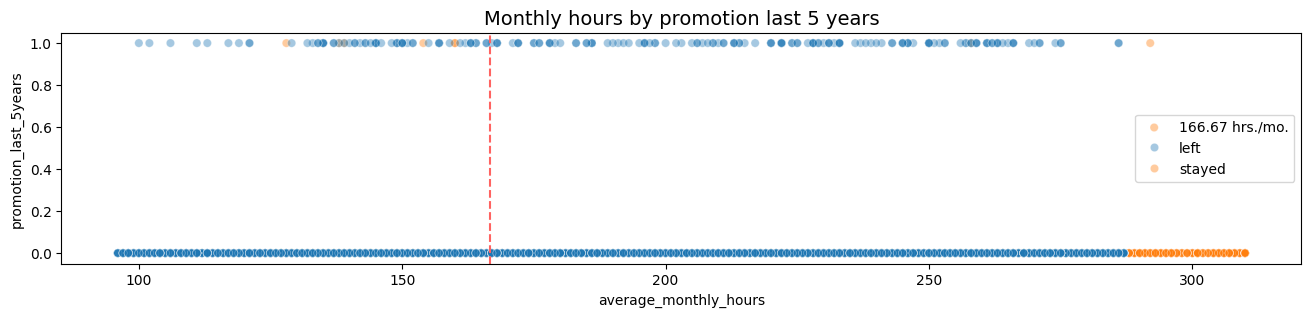

In [23]:
#Lets check if the employees who worked well long hours were promoted in the last five years

#plot to examine relationship between `average_monthly_hours` and `promotion_last_5years`
plt.figure(figsize=(16, 3))
sns.scatterplot(data=df1, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14');

The plot above shows the following:
- very few employees who were promoted in the last five years left
- very few employees who worked the most hours were promoted
- all of the employees who left were working the longest hours

In [24]:
#lets inspect how the employees who left are distrbuted across the departments

df1["department"].value_counts()

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64

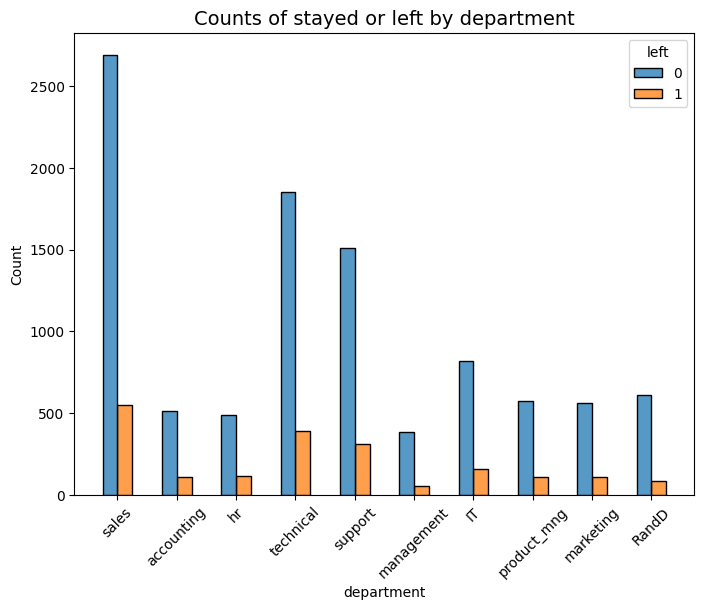

In [25]:
#a stacked histogram to compare department distribution of employees who left to that of employees who didn't
plt.figure(figsize=(8,6))
sns.histplot(data=df1, x='department', hue='left', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation=45)
plt.title('Counts of stayed or left by department', fontsize=14);

From the graph above, there does not seem to be any department that differs significantly in its proportion of employees who left and those who stayed

The correlation heatmap confirms that the number of projects, monthly hours, and evaluation scores all have some positive correlation with each other, and whether an employee leaves is negatively correlated with their satisfaction level.

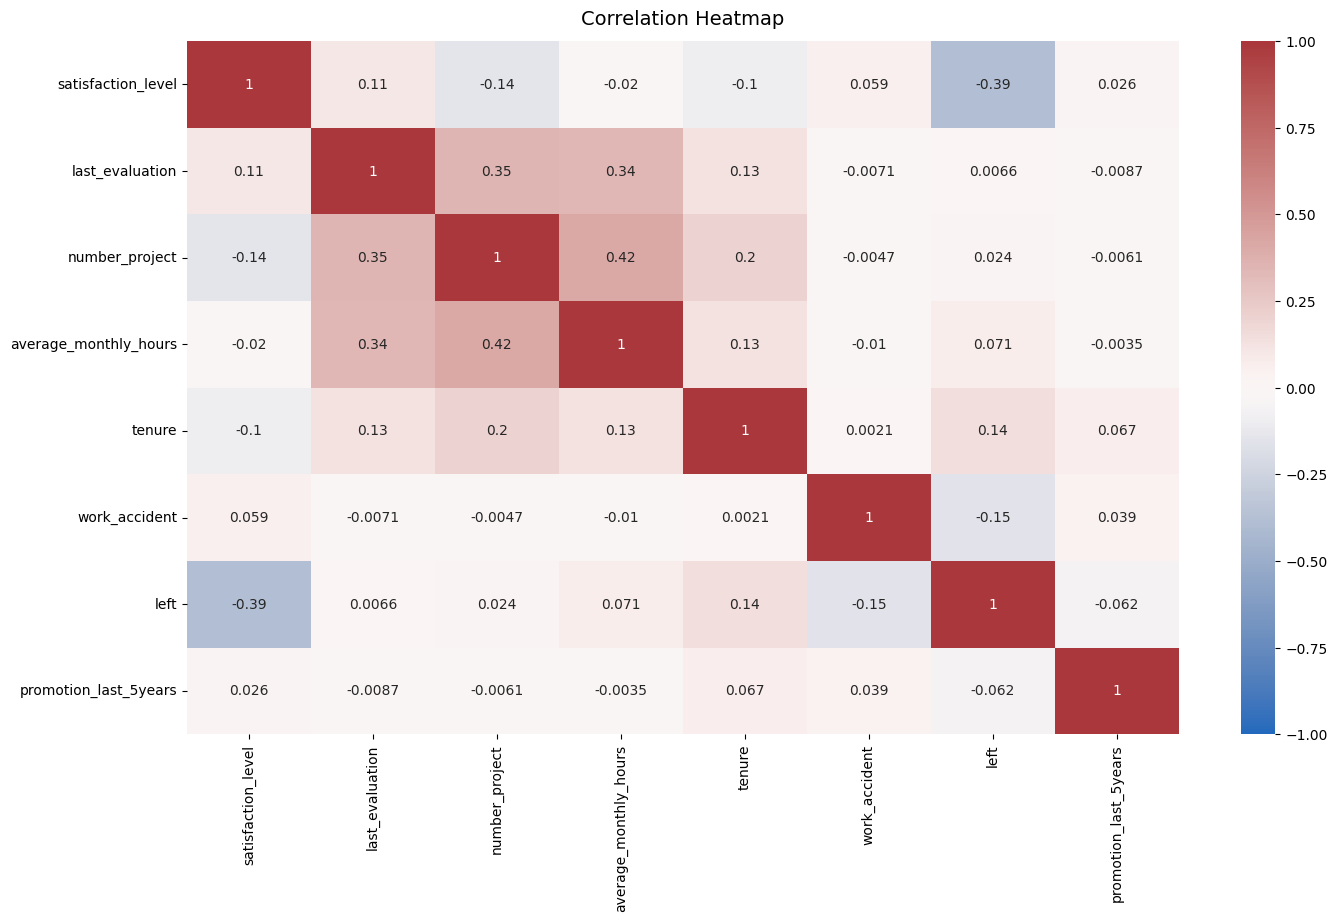

In [26]:
#checking for correlations between variables in the data

#plotting a correlation heatmap
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df0.select_dtypes(include=['number']).corr(),vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

### Insights

It appears that employees are leaving the company as a result of poor management. Leaving is tied to longer working hours, many projects, and generally lower satisfaction levels. It can be very frustrating to work long hours and not receive promotions or good evaluation scores. There's a sizeable group of employees at this company who are probably burned out. 
It also appears that if an employee has spent more than six years at the company, they tend not to leave.

## Construct Stage

Some model assumptions before we begin constructing and executing a machine learning model.
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size

the goal is to predict whether an employee leaves the company, which is a categorical outcome attribute. 
This task involves classigication and specifically, a binary classification since an employee leaving will be 1 and an employee who didn't leave is 0

Lets implement a logistic regression model and a tree based machine learning model to predict whether an employee leaves the company.

##### Model A: Logistic Regression

Before splitting the data into train and test, lets encode the attributes 'department' and 'salary'.

'department' is a categorical variable

'salary' is categorical too but it is ordinal. Converting the salary levels to numbers 0-2

In [27]:
# making a copy of the dataframe
df_enc = df1.copy()

#encoding the `salary` column as an ordinal numeric category
df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

#dummy encoding the `department` column
df_enc = pd.get_dummies(df_enc, drop_first=False)
df_enc.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years  salary  department_IT  \
0       3              0     1                      0       0          False   
1       6              0     1                      0       1          False   
2       4              0     1                      0       1          False   
3       5              0     1                      0       0          False   
4       3              0     1                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
1             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
1                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
1              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False

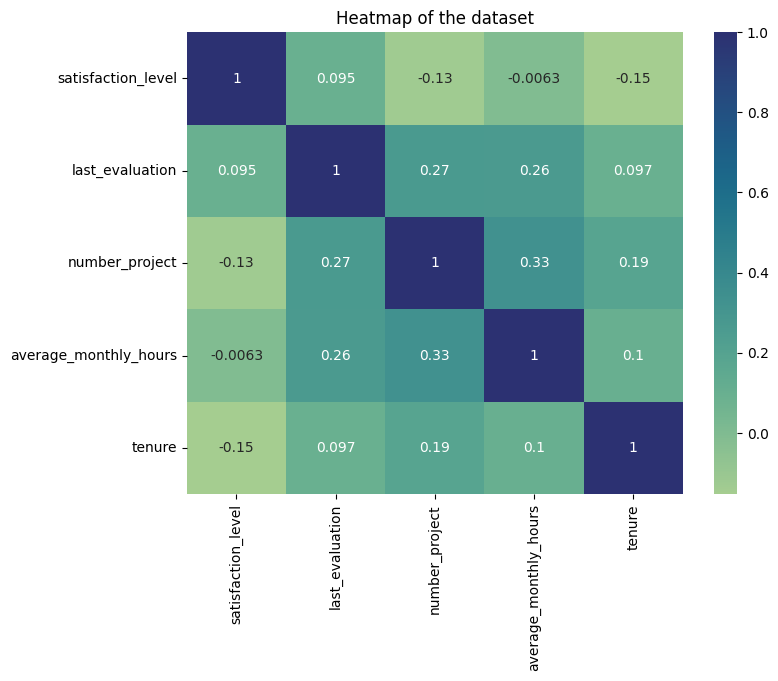

In [28]:
#creating a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

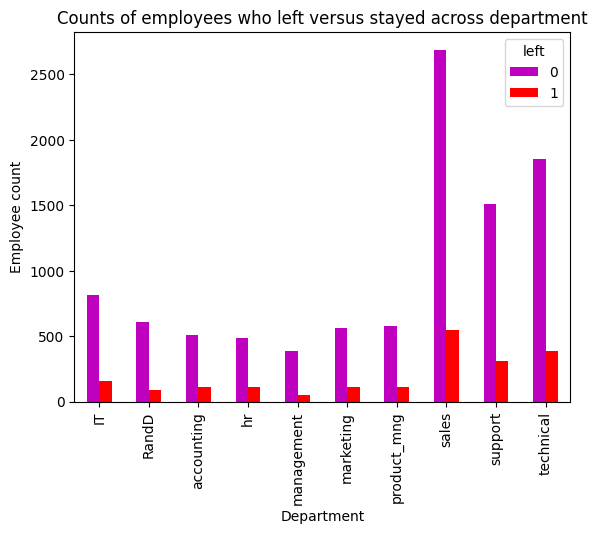

In [29]:
#creating a stacked bar plot to visualize number of employees across department, 
#comparing those who left with those who didn't
#0 (purple) represents employees who did not leave, 1 (red) represents employees who left
pd.crosstab(df1['department'], df1['left']).plot(kind ='bar',color='mr')
plt.title('Counts of employees who left versus stayed across department')
plt.ylabel('Employee count')
plt.xlabel('Department')
plt.show()

In [30]:
#logistic regression is quite sensitive to outliers, it would be a good idea at this stage, 
#to remove the outliers in the tenure column that were identified earlier

#select rows without outliers in `tenure` and save the dataframe in a new variable
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]
df_logreg.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   
5                0.41             0.50               2                    153   

   tenure  work_accident  left  promotion_last_5years  salary  department_IT  \
0       3              0     1                      0       0          False   
2       4              0     1                      0       1          False   
3       5              0     1                      0       0          False   
4       3              0     1                      0       0          False   
5       3              0     1                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   
5             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   
5                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False  
5              True               False                 False

In [31]:
#isolate the outcome variable
y = df_logreg['left']
y.head() 

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

In [32]:
#selecting the predictor
X = df_logreg.drop('left', axis=1)
X.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   
5                0.41             0.50               2                    153   

   tenure  work_accident  promotion_last_5years  salary  department_IT  \
0       3              0                      0       0          False   
2       4              0                      0       1          False   
3       5              0                      0       0          False   
4       3              0                      0       0          False   
5       3              0                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   
5             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   
5                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False  
5              True               False                 False

In [33]:
#splitting the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=101)

In [34]:
#constructing a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=101, max_iter=500).fit(X_train, y_train)

In [35]:
#using the model to make predictions on the test data
y_pred = log_clf.predict(X_test)

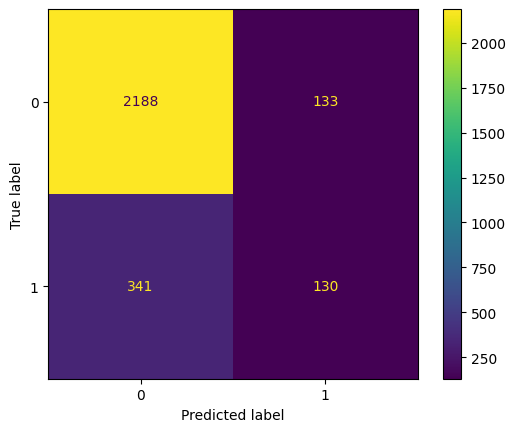

In [36]:
#now creating a onfusion matrix to visualize the results of the logistic regression model

log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)
log_disp.plot(values_format='')
plt.show()

The upper-left quadrant displays the number of true negatives. The upper-right quadrant displays the number of false positives. The bottom-left quadrant displays the number of false negatives. The bottom-right quadrant displays the number of true positives.

- True negatives: The number of people who did not leave that the model accurately predicted did not leave.

- False positives: The number of people who did not leave, the model inaccurately predicted as leaving.

- False negatives: The number of people who left that the model inaccurately predicted did not leave

- True positives: The number of people who left, the model accurately predicted as leaving

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

In [37]:
df_logreg['left'].value_counts(normalize=True)

left
0    0.831468
1    0.168532
Name: proportion, dtype: float64

There is an approximately 83%-17% split. So the data is not perfectly balanced, but it is not too imbalanced. 
If it was more severely imbalanced, we might want to resample the data to make it more balanced. In this case, we can use this data without modifying the class balance and continue evaluating the model.

In [38]:
#creating a classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.87      0.94      0.90      2321
    Predicted would leave       0.49      0.28      0.35       471

                 accuracy                           0.83      2792
                macro avg       0.68      0.61      0.63      2792
             weighted avg       0.80      0.83      0.81      2792



The classification report above shows that the logistic regression model achieved a precision of 79%, recall of 82%, f1-score of 80%(all weighted averages), and accuracy of 82%. However, if it's most important to predict employees who leave, then the scores are significantly lower.

##### Model B: Tree-based Model

In [39]:
#implementing decion tree and random forest
#setting the target variable
y = df_enc['left']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

In [40]:
#selecting the features
X = df_enc.drop('left', axis=1)
X.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  promotion_last_5years  salary  department_IT  \
0       3              0                      0       0          False   
1       6              0                      0       1          False   
2       4              0                      0       1          False   
3       5              0                      0       0          False   
4       3              0                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
1             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
1                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
1              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=101)

##### Decion Tree

In [42]:
#instantiate model
tree = DecisionTreeClassifier(random_state=0)

#assigning a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

#a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

#start GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [43]:
%%time
tree1.fit(X_train, y_train)

CPU times: total: 3.23 s
Wall time: 3.23 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [44]:
#a check for best parameters
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [45]:
#checking best AUC score on CV
tree1.best_score_

np.float64(0.9710526726020654)

This is a strong AUC score, which shows that this model can predict employees who will leave very well.

In [46]:
#a function to extract all the scores from the gridsearch


def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    #create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    #get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    #isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    #extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    #create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [47]:
#using the created function to get all the results
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.924513  0.912254  0.918193  0.972979  0.971053

All of these scores from the decision tree model are strong indicators of good model performance

However,decision trees can be vulnerable to overfitting, and random forests avoid overfitting by incorporating multiple trees to make predictions. 

Constructing a random forest model in the next stage

##### Random Forest

In [48]:
#instantiate model
rf = RandomForestClassifier(random_state=0)

#assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

#assign a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

#instantiate gridsearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [49]:
%%time
rf1.fit(X_train, y_train)  #wall time: approx. 30min

CPU times: total: 18min 58s
Wall time: 19min 7s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [50]:
#defining a path to the folder to save the model
path = "C:/Users/rohan/OneDrive/Desktop/Google Advanced Data Analytics, Capstone Project"

In [51]:
#a function to pickle the model and read it

def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [52]:
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [53]:
#saving the model in a pickle file and then read it in
write_pickle(path, rf1, 'hr_rf1')

In [54]:
#read pickle
rf1 = read_pickle(path, 'hr_rf1')

In [55]:
#check best AUC score on CV
rf1.best_score_

np.float64(0.979713035894348)

In [56]:
#check best params
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [57]:
#collecting evaluation scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.924513  0.912254  0.918193  0.972979  0.971053
              model  precision    recall       F1  accuracy       auc
0  random forest cv   0.950155  0.913593  0.93144  0.977649  0.979713


The random forest model demonstrates superior performance compared to the decision tree model across evaluation metrics, except for a marginal decrease in recall by approximately 0.001. This suggests that, overall, the random forest model excels over the decision tree model in terms of predictive accuracy and generalization.

In [58]:
#Now to evaluate the final model on the test set

In [59]:
#creating a function to get all the scores from model's prediction

def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

In [60]:
#to get predictions on test data
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

model  precision    recall       f1  accuracy       AUC
0  random forest1 test   0.948454  0.923695  0.93591  0.978986  0.956847

The test scores are very similar to the validation scores. This appears to be a strong model. Since this test set was only used for this model, we can be more confident that this model's performance on this data is representative of how it will perform on new, unseen data.

##### Feature Engineering

The first round of decision tree and random forest models included all variables as features. This next round will incorporate feature engineering to build improved models.

dropping `satisfaction_level` and creating a new feature that roughly captures whether an employee is overworked. 
Lets call this feature 'overworked' and it will be binary variable.

In [61]:
#dropping `satisfaction_level` and save resulting dataframe in new variable
df2 = df_enc.drop('satisfaction_level', axis=1)
df2.head()

last_evaluation  number_project  average_monthly_hours  tenure  \
0             0.53               2                    157       3   
1             0.86               5                    262       6   
2             0.88               7                    272       4   
3             0.87               5                    223       5   
4             0.52               2                    159       3   

   work_accident  left  promotion_last_5years  salary  department_IT  \
0              0     1                      0       0          False   
1              0     1                      0       1          False   
2              0     1                      0       1          False   
3              0     1                      0       0          False   
4              0     1                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
1             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
1                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
1              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False

In [62]:
df2['overworked'] = df2['average_monthly_hours']

#to inspect max and min average monthly hours values
print('Max hours:', df2['overworked'].max())
print('Min hours:', df2['overworked'].min())

Max hours: 310
Min hours: 96


In [63]:
#defining overworked as working more than 175 hours per month on average
#df2['overworked'] > 175, will create a series of boolean values and as.type argument will convert True to 1 and False to 0


df2['overworked'] = (df2['overworked'] > 175).astype(int)
df2['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int64

In [64]:
#dropping the `average_monthly_hours` column
df2 = df2.drop('average_monthly_hours', axis=1)
df2.head()

last_evaluation  number_project  tenure  work_accident  left  \
0             0.53               2       3              0     1   
1             0.86               5       6              0     1   
2             0.88               7       4              0     1   
3             0.87               5       5              0     1   
4             0.52               2       3              0     1   

   promotion_last_5years  salary  department_IT  department_RandD  \
0                      0       0          False             False   
1                      0       1          False             False   
2                      0       1          False             False   
3                      0       0          False             False   
4                      0       0          False             False   

   department_accounting  department_hr  department_management  \
0                  False          False                  False   
1                  False          False                  False   
2                  False          False                  False   
3                  False          False                  False   
4                  False          False                  False   

   department_marketing  department_product_mng  department_sales  \
0                 False                   False              True   
1                 False                   False              True   
2                 False                   False              True   
3                 False                   False              True   
4                 False                   False              True   

   department_support  department_technical  overworked  
0               False                 False           0  
1               False                 False           1  
2               False                 False           1  
3               False                 False           1  
4               False                 False           0

In [65]:
#isolating the target and features

y = df2['left']
X = df2.drop('left', axis=1)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=101)

##### Decision Tree : stage 2

In [67]:
tree = DecisionTreeClassifier(random_state=0)

#assigning a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

#a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [68]:
%%time
tree2.fit(X_train, y_train)

CPU times: total: 3.25 s
Wall time: 3.25 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [69]:
tree2.best_params_

{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6}

In [70]:
tree2.best_score_

np.float64(0.9581076218739993)

This model performs very well, even without satisfaction levels and detailed hours worked data

In [71]:
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
print(tree1_cv_results)
print(tree2_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.924513  0.912254  0.918193  0.972979  0.971053
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.824376  0.910922  0.865125  0.952741  0.958108


Some scores fell, its expected as we dropped a few features. Still the scores are good

##### Random Forest - Stage 2

In [72]:
rf = RandomForestClassifier(random_state=0)

#assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [73]:
%%time
rf2.fit(X_train, y_train) # Wall time: 20 min approx

CPU times: total: 13min 9s
Wall time: 13min 12s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [74]:
write_pickle(path, rf2, 'hr_rf2')

In [75]:
rf2 = read_pickle(path, 'hr_rf2')

In [76]:
rf2 = read_pickle(path, 'hr_rf2')

In [77]:
rf2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 300}

In [78]:
rf2.best_score_

np.float64(0.9649894921458713)

In [79]:
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)

               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.824376  0.910922  0.865125  0.952741  0.958108
               model  precision   recall        F1  accuracy       auc
0  random forest2 cv   0.872148  0.90556  0.888422  0.962192  0.964989


In [80]:
#the scores dropped slightly, but the random forest performs better than the decision tree if using AUC as the deciding metric

We have our chapion model and that is the random forest stage 2 model

#checking predictions now

In [81]:
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
rf2_test_scores

model  precision    recall        f1  accuracy       AUC
0  random forest2 test   0.874263  0.893574  0.883813  0.960974  0.933987

Seems to be a stable and well performing model

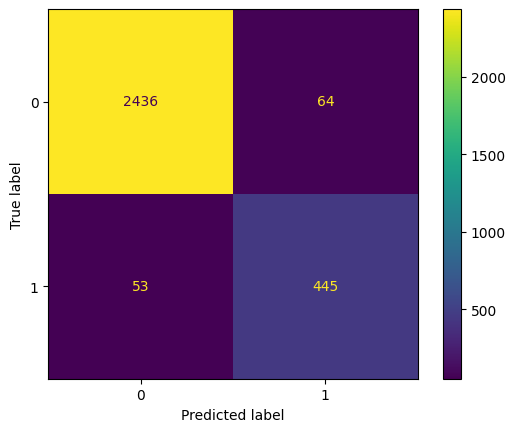

In [82]:
#plotting a confusion matrix
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot(values_format='')

While the model exhibits a tendency to generate more false positives than false negatives, indicating that it might occasionally flag employees as potential attrition risks incorrectly, it remains a robust and effective tool.

In [83]:
#lets inspect the splits of the decision tree model and identify the most important features

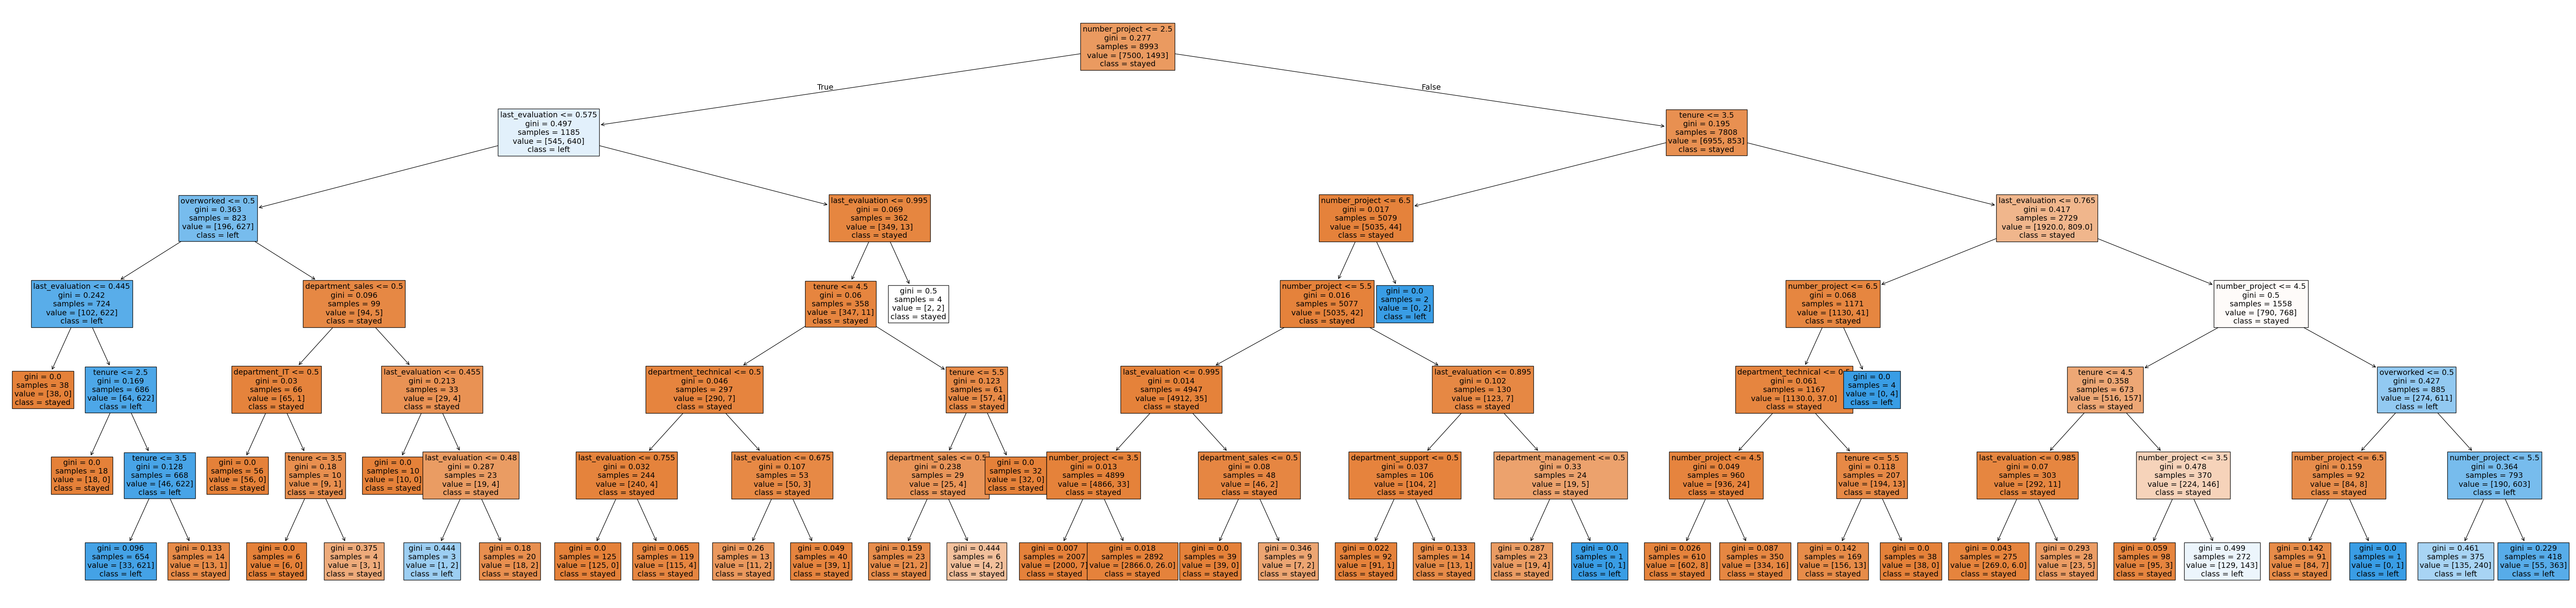

In [84]:
#plot the tree
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

In [85]:
#Note: double click on the tree to zoom

##### Decision Tree feature importance

In [86]:
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

#only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

gini_importance
number_project                0.338808
last_evaluation               0.338686
tenure                        0.215826
overworked                    0.104471
department_sales              0.000994
department_management         0.000724
department_technical          0.000347
department_IT                 0.000094
department_support            0.000049

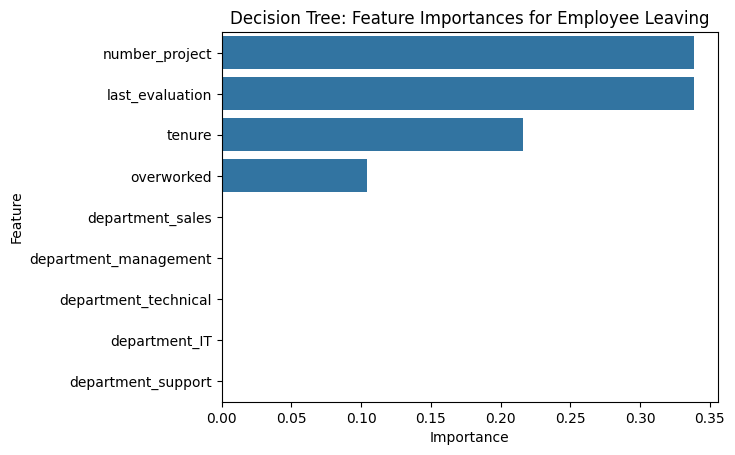

In [87]:
#creating a barplot to visualize the results
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

The barplot above shows that in this decision tree model, last_evaluation, number_project, tenure, and overworked have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, left.

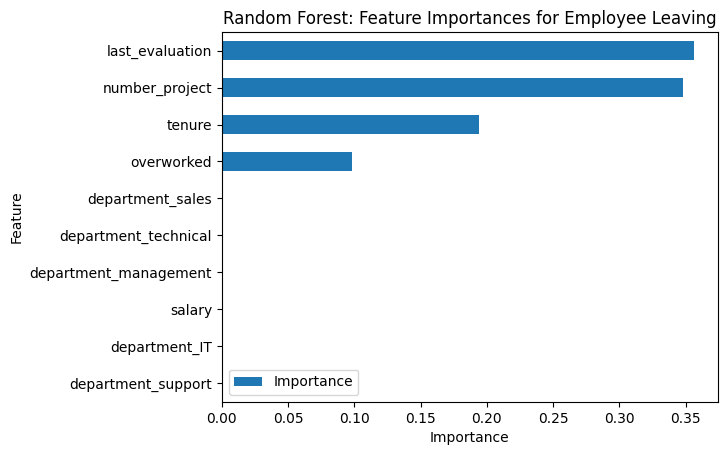

In [88]:
#Random forest feature importance

feat_impt = rf2.best_estimator_.feature_importances_

#getting indices of top 10 features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]
#column labels of top 10 features 
feat = X.columns[ind]

#filtering `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

The plot above shows that in this random forest model, last_evaluation, number_project, tenure, and overworked have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, left, and they are the same as the ones used by the decision tree model.

### Summary and conclusions after evaluation:

Logistic Regression

- The logistic regression model achieved precision of 80%, recall of 83%, f1-score of 80% (all weighted averages), and accuracy of 83%, on the test set.

Tree-based Machine Learning

- After conducting feature engineering, the decision tree model achieved AUC of 93.8%, precision of 87.0%, recall of 90.4%, f1-score of 88.7%, and accuracy of 96.2%, on the test set. The random forest modestly outperformed the decision tree model.

### Recommendation

The models and the feature importances extracted from the models confirm that employees at the company are overworked.

- Implement a limit on the number of projects assigned to each employee to prevent overwork and burnout.
- Consider promotions for employees who have dedicated at least four years to the company, or investigate reasons behind their dissatisfaction.
- Provide incentives for employees working extended hours, or consider flexible work arrangements to maintain a healthy work-life balance.
- Ensure all employees are well-informed about the company's overtime pay policies, and establish clear guidelines for workload expectations and time off.
- Facilitate open discussions at both company-wide and team levels to better understand and enhance the overall work culture.
- Evaluate employees based on proportional effort rather than solely on hours worked, to recognize and reward contributions effectively.